Computes the burst drift of an FRB using a 2d autocorrelation

author: moh, based on victor's ectrture_matrice_intensite.py dat: march 28, 2020


In [1]:
#!/usr/bin/python3

from __future__ import division
import math
import os
import sys
import time
import numpy as np
import scipy.stats
from scipy.optimize import curve_fit
from math import log10
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import pi as nombrepi
from scipy import signal, ndimage
from tqdm import tqdm
from matplotlib import colors as mcolors
import functools
print = functools.partial(print, flush=True) # print doesn't happen til script ends so force it to flush... windows thing?

burst = 16

junk, nchan, nbin, I, Q, U, V = np.loadtxt('data/{}_puppi_57772_C0531+33_0007_2695.dm559.72.calibP.RM.DD.ASCII'.format(burst), delimiter=' ', unpack=True)
n = len(junk)
print("Data loaded")

Data loaded


In [2]:
binmax = int(nbin[n-1])+1
frequencymax = (int(nchan[n-1])+1)
print("dimensions:", binmax, frequencymax)
intensity = np.zeros((frequencymax, binmax))

X = np.zeros(binmax)
Y = np.zeros(frequencymax)

tmin = 500

tmax = 1500

intensitynoise1 = np.zeros(tmin-1)
intensitynoise2 = np.zeros(binmax-tmax)
for i in tqdm(range(frequencymax-50,51,-1), desc='noise removal'):

	Y[i-1] = 4.15 + (i-1) * 1.5625 # ?

	for j in range(1,tmin) :

		intensitynoise1[j-1] = (I[j-1 + binmax*(frequencymax-i)])/(tmin-1)


	for j in range(tmax+1,binmax+1) :

		intensitynoise2[j-1-tmax] = (I[j-1 + binmax*(frequencymax-i)])/(binmax-tmax)

	a = sum(intensitynoise1)
	b = sum(intensitynoise2)

	for j in range(1,binmax+1) :
		X[j-1] = j-1
		intensity[i-1,j-1] = I[j-1 + binmax*(frequencymax-i)] - (a+b)/2

for i in tqdm(range(52,frequencymax-49), desc='variance'):
	for j in range(tmax+1,binmax+1) :
		intensitynoise2[j-1-tmax] = intensity[i-1,j-1]

	mean = np.mean(intensitynoise2)
	variance = np.var(intensitynoise2)
# del intensitynoise1
# del intensitynoise2
# del junk, nchan, nbin, I, Q, U, V

dimensions: 4096 512


variance: 100%|██████████| 411/411 [00:00<00:00, 554.54it/s]


In [3]:
print(len(intensity), len(intensity[0]))

512 4096


finding auto-correlation...
omg finally finished


Text(0.5, 1.0, 'Correlation #16')

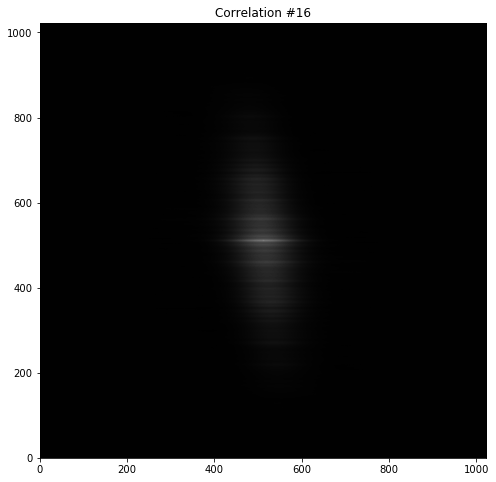

In [4]:
edge = 700
burstwindow = intensity[:,edge:edge+frequencymax]

print("finding auto-correlation...")
corr = signal.correlate2d(burstwindow, burstwindow, mode='full')
print('omg finally finished')
# Plot

# abscisse,ordonnee = np.meshgrid(X,Y)

cmap = "gray"
plt.figure(figsize=(8,8))
# plt.imshow(intensity, cmap=cmap, interpolation='bicubic',aspect='auto', origin="lower")
plt.imshow(corr, cmap=cmap, interpolation='bicubic',aspect='auto', origin="lower")
plt.title("Correlation #{}".format(burst))

(512, 512)


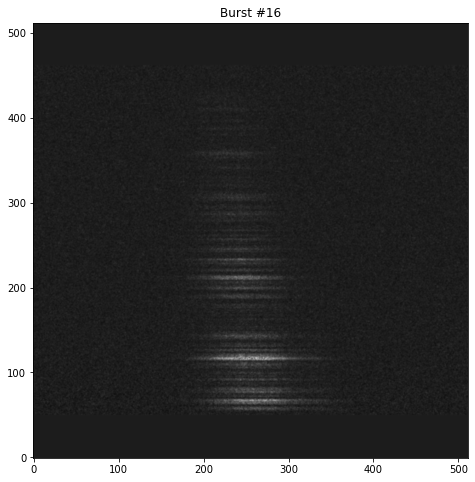

In [5]:
plt.figure(figsize=(8,8))
plt.title("Burst #{}".format(burst))
# plt.imshow(intensity, cmap=cmap, interpolation='bicubic',aspect='auto', origin="lower")

plt.imshow(burstwindow, cmap=cmap, interpolation='bicubic',aspect='equal', origin="lower")
print(burstwindow.shape)

# Fit

In [97]:
# Source: https://gist.github.com/andrewgiessel/6122739
# Source: https://stackoverflow.com/questions/21566379/fitting-a-2d-gaussian-function-using-scipy-optimize-curve-fit-valueerror-and-m
def gaussian(height, center_x, center_y, width_x, width_y, rotation):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)

    rotation = np.deg2rad(rotation)
    center_x_old = center_x
    center_x = center_x * np.cos(rotation) - center_y * np.sin(rotation)
    center_y = center_x_old * np.sin(rotation) + center_y * np.cos(rotation)

    def rotgauss(x,y):
        xp = x * np.cos(rotation) - y * np.sin(rotation)
        yp = x * np.sin(rotation) + y * np.cos(rotation)
        g = height*np.exp( -(((center_x-xp)/width_x)**2  +((center_y-yp)/width_y)**2)/2.  )
        return g
    return rotgauss

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y, 2.0

def twoD_Gaussian(point, amplitude, xo, yo, sigma_x, sigma_y, theta):
    x, y = point
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))
    return g.ravel()

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) - data)
    p, success = scipy.optimize.leastsq(errorfunction, params)
    return p, success

def fitgaussiannlsq(data):
    # use curve-fit (non-linear leastsq)
    x = range(0, 1023); y = range(0, 1023)
    x, y = np.meshgrid(x, y)
    params = moments(data)#+ (0.,)
    popt, pcov = scipy.optimize.curve_fit(twoD_Gaussian, (x, y), corr.ravel(), p0=params)
    return popt, pcov

p, success = fitgaussian(corr)
popt, pcov = fitgaussiannlsq(corr)
print('success? (nonzero):', success)
fit = gaussian(*p)
x = range(0, 1023); y = range(0, 1023)
x, y = np.meshgrid(x, y)
fitmap2 = twoD_Gaussian((x, y), *popt).reshape(1023, 1023)
# fit = gaussian(12309.30062645451, 511.0000000000002, 511.0000000000002, 126.10568482796336, 55.80036552617748, 2)
print('solution:', p)
print('solution nlsq:', popt)
print('initial guess:', moments(corr))

success? (nonzero): 1
solution: [2624.00784505  511.          511.          124.6691063    46.77818949
    7.69144294]
solution nlsq: [2.62401354e+03 5.11000000e+02 5.11000000e+02 1.24668498e+02
 4.67782145e+01 1.43655485e+00]
initial guess: (12309.30062645451, 511.0000000000002, 511.0000000000002, 126.10568482796336, 55.80036552617748, 2.0)


100%|██████████| 1023/1023 [00:19<00:00, 51.78it/s]


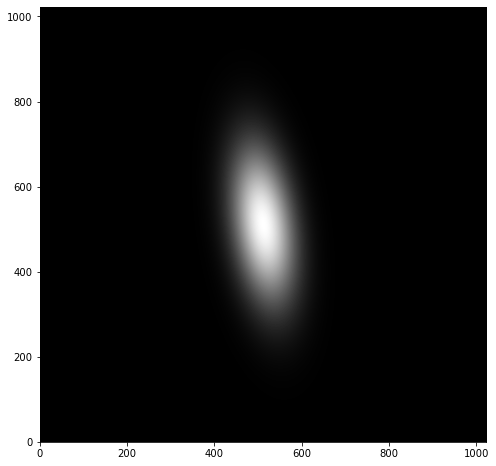

In [90]:
fitmap = np.zeros((len(corr), len(corr[0])))
for y in tqdm(range(0, len(corr))):
    for x in range(0, len(corr[0])):
        fitmap[x][y] = fit(x, y)

plt.figure(figsize=(8,8))
plt.imshow(fitmap, cmap=cmap, interpolation='bicubic',aspect='auto', origin="lower")

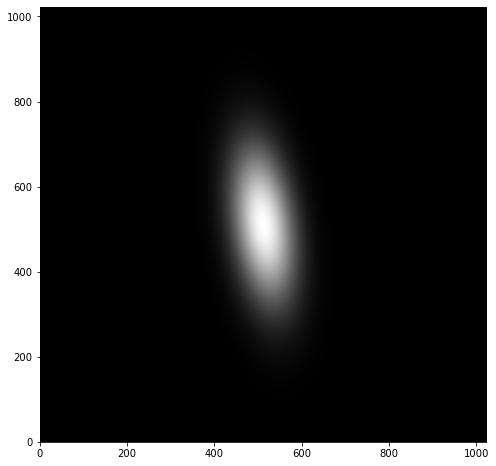

In [98]:
plt.figure(figsize=(8,8))
plt.imshow(fitmap2, cmap=cmap, interpolation='bicubic',aspect='auto', origin="lower")

Text(0.5, 1.0, 'Correlation #16')

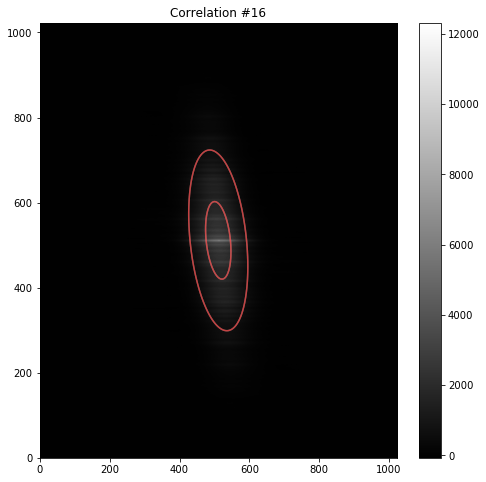

In [99]:
cmap = "gray"
plt.figure(figsize=(8,8))
# plt.imshow(intensity, cmap=cmap, interpolation='bicubic',aspect='auto', origin="lower")
plt.imshow(corr, cmap=cmap, interpolation='bicubic',aspect='auto', origin="lower")
plt.colorbar()
plt.contour(*np.meshgrid(range(0, 1023), range(0, 1023)), fitmap, [600, 2000], colors='w', alpha=0.5)
plt.contour(*np.meshgrid(range(0, 1023), range(0, 1023)), fitmap2, [600, 2000], colors='r', alpha=0.5)
plt.title("Correlation #{}".format(burst))